In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import tree
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV,TimeSeriesSplit, cross_val_score



# Veriyi yükleme
data = pd.read_csv('match_data')



Data Preprocessing

In [20]:

# Eksik değerleri olan sütunların adları ve sayıları
missing_columns = data.isnull().sum()

# 0'dan fazla eksik değeri olan sütunları filtreleyip yazdırma
missing_columns = missing_columns[missing_columns > 0]

# Eksik değerleri olan tüm sütunları ekrana yazdırma
print("Eksik değeri olan sütunlar ve sayıları:")
print(missing_columns.to_string()) 

# current_state sütunundaki eksik değerleri silme
data.dropna(subset=['current_state'], inplace=True)

# Diğer sütunlar için daha hızlı eksik veri doldurma
# Önce fixture_id'ye göre grupla ve forward fill yap
columns_with_nulls = [col for col in data.columns if col != 'current_state' and data[col].isnull().sum() > 0]
data.sort_values(['fixture_id', 'current_time'], inplace=True)
data[columns_with_nulls] = data.groupby('fixture_id')[columns_with_nulls].transform(lambda x: x.ffill().round())

# Kalan eksik değerleri 0 ile doldur
data.fillna(0, inplace=True)

# Güncellenmiş veriyi kontrol etme
print("Eksik değerlerin bulunduğu sütunlar (temizlemeden sonra):\n", data.isnull().sum())



Eksik değeri olan sütunlar ve sayıları:
Accurate Crosses - away                 3028
Accurate Crosses - home                 3007
Assists - away                         27934
Assists - home                         27931
Attacks - away                            39
Attacks - home                            33
Ball Possession % - away                  23
Ball Possession % - home                  22
Ball Safe - away                       23428
Ball Safe - home                       23424
Challenges - away                       4681
Challenges - home                       4674
Corners - away                            74
Corners - home                            66
Counter Attacks - away                 41211
Counter Attacks - home                 41209
Dangerous Attacks - away                  53
Dangerous Attacks - home                  47
Dribble Attempts - away                 7869
Dribble Attempts - home                 7844
Fouls - away                            1627
Fouls - home   

In [21]:
data.loc[data['result'] == 'X', 'result'] = 0
data.loc[data['current_state'] == 'X', 'current_state'] = 0

data['current_state'] = data['current_state'].astype(int)
data['result'] = data['result'].astype(int)

# Convert current_time to datetime
data['current_time'] = pd.to_datetime(data['current_time'])
data.to_csv('filled_match_groups_2.csv', index=False)

In [22]:
# Olasılıkların hesaplanması
data['P_home'] = 1 / data['1']
data['P_draw'] = 1 / data['X']
data['P_away'] = 1 / data['2']

data['P_sum'] = data['P_home'] + data['P_draw'] + data['P_away']
data['P_home_norm'] = data['P_home'] / data['P_sum']
data['P_draw_norm'] = data['P_draw'] / data['P_sum']
data['P_away_norm'] = data['P_away'] / data['P_sum']



/var/folders/ys/74vbprgx5wb7ggv44nbd6f240000gn/T/ipykernel_4648/2818227534.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['P_away_norm'] = data['P_away'] / data['P_sum']


In [23]:
def calculate_last_five_minute_average(data):
    # Convert current_time to datetime once for the entire DataFrame
    data['current_time'] = pd.to_datetime(data['current_time'], errors='coerce')
    
    # Create a new DataFrame to store results
    results = pd.DataFrame(index=data.index, columns=['last_5_min_avg_1', 'last_5_min_avg_X', 'last_5_min_avg_2', 
                                                      'last_5_min_std_1', 'last_5_min_std_X', 'last_5_min_std_2'])

    for index, row in data.iterrows():
        current_time = row['current_time']
        fixture_id = row['fixture_id']
        
        # Check if current_time is valid
        if pd.isnull(current_time):
            results.loc[index] = row[['1', 'X', '2']].values.tolist() + [0, 0, 0]
            continue
        
        # Calculate the time window for the last 5 minutes
        time_window_start = current_time - pd.Timedelta(minutes=5)
        
        # Filter the data for the same fixture_id and within the last 5 minutes
        recent_data = data[(data['fixture_id'] == fixture_id) & 
                           (data['current_time'] >= time_window_start) & 
                           (data['current_time'] <= current_time)]
        
        # Calculate the average and standard deviation for '1', 'X', and '2' columns
        if not recent_data.empty:
            avg_values = recent_data[['1', 'X', '2']].mean().values
            std_values = recent_data[['1', 'X', '2']].std().values
            results.loc[index] = avg_values.tolist() + std_values.tolist()
        else:
            results.loc[index] = row[['1', 'X', '2']].values.tolist() + [0, 0, 0]

    # Assign results back to the original DataFrame
    data[['last_5_min_avg_1', 'last_5_min_avg_X', 'last_5_min_avg_2', 
          'last_5_min_std_1', 'last_5_min_std_X', 'last_5_min_std_2']] = results

# Call the function to add the columns to the data DataFrame
calculate_last_five_minute_average(data)


/var/folders/ys/74vbprgx5wb7ggv44nbd6f240000gn/T/ipykernel_4648/1763149710.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[['last_5_min_avg_1', 'last_5_min_avg_X', 'last_5_min_avg_2',
/var/folders/ys/74vbprgx5wb7ggv44nbd6f240000gn/T/ipykernel_4648/1763149710.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[['last_5_min_avg_1', 'last_5_min_avg_X', 'last_5_min_avg_2',
/var/folders/ys/74vbprgx5wb7ggv44nbd6f240000gn/T/ipykernel_4648/1763149710.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usu

In [24]:
data[['last_5_min_std_1', 'last_5_min_std_X', 'last_5_min_std_2']] = data[[ 
      'last_5_min_std_1', 'last_5_min_std_X', 'last_5_min_std_2']].fillna(0)

data.head()

/var/folders/ys/74vbprgx5wb7ggv44nbd6f240000gn/T/ipykernel_4648/1277698379.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[['last_5_min_std_1', 'last_5_min_std_X', 'last_5_min_std_2']] = data[[


,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,suspended,stopped,...,P_sum,P_home_norm,P_draw_norm,P_away_norm,last_5_min_avg_1,last_5_min_avg_X,last_5_min_avg_2,last_5_min_std_1,last_5_min_std_X,last_5_min_std_2
952,19134453.0,1st-half,2024-08-16 19:01:19,2024-08-16 19:00:31,2024-08-16 19:00:31,0,48,2024-08-16 19:01:17,False,False,...,1.052410,0.572410,0.237550,0.190040,1.66,4.0,5.0,0.000000,0.0,0.000000
953,19134453.0,1st-half,2024-08-16 19:02:18,2024-08-16 19:00:31,2024-08-16 19:00:31,1,47,2024-08-16 19:02:16,False,False,...,1.052410,0.572410,0.237550,0.190040,1.66,4.0,5.0,0.000000,0.0,0.000000
954,19134453.0,1st-half,2024-08-16 19:03:19,2024-08-16 19:00:31,2024-08-16 19:00:31,2,48,2024-08-16 19:03:15,False,False,...,1.052936,0.589891,0.237431,0.172677,1.643333,4.0,5.166667,0.028868,0.0,0.288675
955,19134453.0,1st-half,2024-08-16 19:04:18,2024-08-16 19:00:31,2024-08-16 19:00:31,3,47,2024-08-16 19:04:08,False,False,...,1.071118,0.579878,0.233401,0.186721,1.635,4.0,5.125,0.028868,0.0,0.250000
956,19134453.0,1st-half,2024-08-16 19:05:19,2024-08-16 19:00:31,2024-08-16 19:00:31,4,48,2024-08-16 19:05:15,False,False,...,1.071118,0.579878,0.233401,0.186721,1.63,4.0,5.1,0.027386,0.0,0.223607


In [25]:
# Kategorik değişkenleri ayrı ayrı encode et
halftime_encoder = LabelEncoder()

# Kategorik değişkenleri sayısala çevirme
data['halftime'] = halftime_encoder.fit_transform(data['halftime'])

In [26]:

# Split into training and test sets based on date
data = data.sort_values(['fixture_id', 'current_time'])
test_start_date = '2024-11-01'
validation_start_date =  '2024-10-20'
train_data = data[data['current_time'] < validation_start_date]
validation_data = data[(data['current_time'] < test_start_date)& (data['current_time'] >= validation_start_date)]
test_data = data[data['current_time'] >= test_start_date]

validation_data.head()

,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,suspended,stopped,...,P_sum,P_home_norm,P_draw_norm,P_away_norm,last_5_min_avg_1,last_5_min_avg_X,last_5_min_avg_2,last_5_min_std_1,last_5_min_std_X,last_5_min_std_2
45325,19134516.0,0,2024-10-20 15:33:19,2024-10-20 15:31:56,2024-10-20 15:31:56,1,23,2024-10-20 15:33:17,False,False,...,1.046854,0.575448,0.212276,0.212276,1.66,4.5,4.5,0.000000,0.000000,0.000000
45326,19134516.0,0,2024-10-20 15:34:24,2024-10-20 15:31:56,2024-10-20 15:31:56,2,28,2024-10-20 15:34:17,False,False,...,1.055579,0.570691,0.210522,0.218787,1.66,4.5,4.415,0.000000,0.000000,0.120208
45327,19134516.0,0,2024-10-20 15:35:28,2024-10-20 15:31:56,2024-10-20 15:31:56,3,32,2024-10-20 15:35:18,False,False,...,1.064303,0.566013,0.216993,0.216993,1.66,4.443333,4.386667,0.000000,0.098150,0.098150
45328,19134516.0,0,2024-10-20 15:36:19,2024-10-20 15:31:56,2024-10-20 15:31:56,4,23,2024-10-20 15:36:13,False,False,...,1.062342,0.547277,0.217394,0.235329,1.675,4.415,4.29,0.030000,0.098150,0.209284
45329,19134516.0,0,2024-10-20 15:37:18,2024-10-20 15:31:56,2024-10-20 15:31:56,5,22,2024-10-20 15:37:13,False,False,...,1.062342,0.547277,0.217394,0.235329,1.684,4.398,4.232,0.032863,0.093113,0.222868


In [27]:
print("Validation seti içindeki fixture sayısı:", validation_data["fixture_id"].nunique())
print("Test seti içindeki fixture sayısı:", test_data["fixture_id"].nunique())
print("Train seti içindeki fixture sayısı:", train_data["fixture_id"].nunique())

Validation seti içindeki fixture sayısı: 92
Test seti içindeki fixture sayısı: 111
Train seti içindeki fixture sayısı: 445


In [28]:
## Simple Decision Tree

X_train = train_data.drop(columns=['current_time', 'half_start_datetime', 'match_start_datetime', 
                                  'latest_bookmaker_update', 'suspended', 'stopped', 'ticking', 'final_score',
                                  'name','fixture_id','result'])

X_train_logistic = X_train.copy()

X_val = validation_data.drop(columns=['current_time', 'half_start_datetime', 'match_start_datetime', 
                                  'latest_bookmaker_update', 'suspended', 'stopped', 'ticking', 'final_score',
                                  'name','fixture_id','result'])

X_val_logistic = X_val.copy()

X_test = test_data.drop(columns=['current_time', 'half_start_datetime', 'match_start_datetime',
                                'latest_bookmaker_update', 'suspended', 'stopped', 'ticking', 'final_score', 
                                'name','fixture_id','result'])
X_test_logistic = X_test.copy()

y_train = train_data['result'].copy()  # result değerini güncellemiyoruz
y_train_logistic = y_train.copy()


y_val = validation_data['result'].copy()  # result değerini güncellemiyoruz
y_val_logistic = y_val.copy()

y_test = test_data['result'].copy()    # result değerini güncellemiyoruz
y_test_logistic = y_test.copy()

clf = DecisionTreeClassifier(random_state=42, max_depth=15, min_samples_split=20)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_val = clf.predict(X_val)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


accuracy_val = accuracy_score(y_val, y_pred_val)
print(f'Validation Accuracy: {accuracy_val * 100:.2f}%')


Accuracy: 56.39%
Validation Accuracy: 54.56%


In [29]:
## Logistic Regression

# Ölçeklendirme (Standartlaştırma)
scaler = StandardScaler()
X_train_logistic_scaled = scaler.fit_transform(X_train_logistic)
X_val_logistic_scaled = scaler.transform(X_val_logistic)
X_test_logistic_scaled = scaler.transform(X_test_logistic)

param_grid = {
    'solver': ['lbfgs', 'saga'],
    'C': [0.1, 1.0, 10.0],  # Regularization strength
    'max_iter': [1000, 2000, 3000],
}

#rid_search = GridSearchCV(
#   LogisticRegression(multi_class='multinomial', random_state=42),
#   param_grid,
#   cv=5,
#   scoring='accuracy'
#
#
#rid_search.fit(X_train_logistic_scaled, y_train_logistic)
#rint(f"Best parameters: {grid_search.best_params_}")


# Logistic Regression modelini oluşturma
logis_reg_model = LogisticRegression(
    solver='lbfgs',  # Varsayılan çözümleyici (uygun ve hızlı)
    max_iter=1000,   # Daha yüksek iterasyon sınırı
    C=0.1,
    random_state=42
)

# Modeli eğitme
logis_reg_model.fit(X_train_logistic_scaled, y_train_logistic)

# Tahmin olasılıklarını hesaplama
train_probabilities_logis_reg = logis_reg_model.predict_proba(X_train_logistic_scaled)

val_probabilities_logis_reg = logis_reg_model.predict_proba(X_val_logistic_scaled)
test_probabilities_logis_reg = logis_reg_model.predict_proba(X_test_logistic_scaled)

# Veri çerçevesine olasılıkları ekleme
data.loc[train_data.index, 'win_probability_1_logis_reg'] = train_probabilities_logis_reg[:, 0]  # 0 için olasılık ekleniyor
data.loc[train_data.index, 'win_probability_2_logis_reg'] = train_probabilities_logis_reg[:, 1]  # 1 için olasılık ekleniyor
data.loc[train_data.index, 'win_probability_X_logis_reg'] = train_probabilities_logis_reg[:, 2]  # 2 için olasılık ekleniyor

data.loc[validation_data.index, 'win_probability_1_logis_reg'] = val_probabilities_logis_reg[:, 0]  # 0 için olasılık ekleniyor
data.loc[validation_data.index, 'win_probability_2_logis_reg'] = val_probabilities_logis_reg[:, 1]  # 1 için olasılık ekleniyor
data.loc[validation_data.index, 'win_probability_X_logis_reg'] = val_probabilities_logis_reg[:, 2]  # 2 için olasılık ekleniyor

data.loc[test_data.index, 'win_probability_1_logis_reg'] = test_probabilities_logis_reg[:, 0]  # 0 için olasılık ekleniyor
data.loc[test_data.index, 'win_probability_2_logis_reg'] = test_probabilities_logis_reg[:, 1]  # 1 için olasılık ekleniyor
data.loc[test_data.index, 'win_probability_X_logis_reg'] = test_probabilities_logis_reg[:, 2]  # 2 için olasılık ekleniyor

# Test seti üzerinde tahminler

y_pred_logis_reg = logis_reg_model.predict(X_test_logistic_scaled)
y_pred_val_logis_reg = logis_reg_model.predict(X_val_logistic_scaled)

# Tahminleri veri setine ekleme
data.loc[test_data.index, 'predictions_logis_reg'] = y_pred_logis_reg  # Tahminleri ekleme
data.loc[validation_data.index, 'predictions_logis_reg'] = y_pred_val_logis_reg  # Tahminleri ekleme
# Model performansı değerlendirme
accuracy_logis_reg = accuracy_score(y_test_logistic, y_pred_logis_reg)
print(f"\nDoğru Tahmin Oranı: {accuracy_logis_reg:.2%}")

accuracy_logis_reg_val = accuracy_score(y_val_logistic, y_pred_val_logis_reg)
print(f"\nValidation Doğru Tahmin Oranı: {accuracy_logis_reg_val:.2%}")


# Detaylı performans metrikleri
precision_logis_reg = precision_score(y_test_logistic, y_pred_logis_reg, average=None)
recall_logis_reg = recall_score(y_test_logistic, y_pred_logis_reg, average=None)
f1_logis_reg = f1_score(y_test_logistic, y_pred_logis_reg, average=None)

metrics_logis_reg_df = pd.DataFrame({
    'Sınıf': ['0', '1', '2'],
    'Precision': precision_logis_reg,
    'Recall': recall_logis_reg,
    'F1-score': f1_logis_reg
})
print("\nModel Performans Metrikleri (Logistic Regression):")
print(metrics_logis_reg_df.to_string(index=False))


Doğru Tahmin Oranı: 61.91%

Validation Doğru Tahmin Oranı: 58.26%

Model Performans Metrikleri (Logistic Regression):
Sınıf  Precision   Recall  F1-score
    0   0.363043 0.402642  0.381818
    1   0.746410 0.713125  0.729388
    2   0.616645 0.614832  0.615737


In [30]:
# RANDOM FOREST KODU:

# NaN değerleri doldur
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Sınıf dağılımını kontrol et
print("Eğitim setindeki sınıf dağılımı:")
print(y_train.value_counts(normalize=True))

# SMOTE ile dengesiz veri setini dengele
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


Eğitim setindeki sınıf dağılımı:
result
1    0.423456
2    0.300708
0    0.275835
Name: proportion, dtype: float64


In [ ]:
## Parameter tuning for random forest ( uzun sürüyor)
# Grid search için parametre setleri
param_grid = {
    'n_estimators': [500, 1000,1500],
    'max_depth': [15, 20],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [4, 6]
}

# Model oluştur
rf = RandomForestClassifier(max_features='sqrt', random_state=42, n_jobs=-1)

# GridSearchCV tanımla
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,        
    n_jobs=-1,
    verbose=2
)

# Modeli eğit
grid_search.fit(X_train_balanced, y_train_balanced)


# En iyi parametreler ve skor
print("En iyi parametreler:", grid_search.best_params_)


In [31]:
# Random Forest modelini oluştur
rf_model = RandomForestClassifier(
    n_estimators= 500,#1000,
    max_depth=20,
    min_samples_split=5, #10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1
)

#tscv = TimeSeriesSplit(n_splits=5)
#cv_scores = cross_val_score(rf_model, X_train, y_train, cv=tscv)
#print(f"Time Series Cross-validation scores: {cv_scores}")
#print(f"Average CV score: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Modeli eğit
rf_model.fit(X_train_balanced, y_train_balanced)

# Tahmin olasılıklarını hesapla
train_probabilities = rf_model.predict_proba(X_train)
validation_probabilities = rf_model.predict_proba(X_val)
test_probabilities = rf_model.predict_proba(X_test)

# Kazanma olasılıklarını data frame'e ekle
data.loc[train_data.index, 'win_probability_1'] = train_probabilities[:, 1]  # 1 için olasılık ekleniyor
data.loc[train_data.index, 'win_probability_2'] = train_probabilities[:, 2]  # 2 için olasılık ekleniyor
data.loc[train_data.index, 'win_probability_X'] = train_probabilities[:, 0]  # X için olasılık ekleniyor

data.loc[validation_data.index, 'win_probability_1'] = validation_probabilities[:, 1]  # 1 için olasılık ekleniyor
data.loc[validation_data.index, 'win_probability_2'] = validation_probabilities[:, 2]  # 2 için olasılık ekleniyor
data.loc[validation_data.index, 'win_probability_X'] = validation_probabilities[:, 0]  # X için olasılık ekleniyor

data.loc[test_data.index, 'win_probability_1'] = test_probabilities[:, 1]  # 1 için olasılık ekleniyor
data.loc[test_data.index, 'win_probability_2'] = test_probabilities[:, 2]  # 2 için olasılık ekleniyor
data.loc[test_data.index, 'win_probability_X'] = test_probabilities[:, 0]  # X için olasılık ekleniyor

# Validation seti üstünden tahmin yap
y_pred_val = rf_model.predict(X_val)

# Test seti üzerinde tahmin yap
y_pred = rf_model.predict(X_test)

# Tahminleri ana veri setine ekleyelim
data.loc[test_data.index, 'predictions'] = y_pred  # Tahmin edilen değerleri ekliyoruz
data.loc[validation_data.index, 'predictions'] = y_pred_val  # Tahmin edilen değerleri ekliyoruz
# Model performansını değerlendir
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Seti Doğru Tahmin Oranı: {accuracy:.2%}")

val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"\nValidation Seti Doğru Tahmin Oranı: {val_accuracy:.2%}")




Test Seti Doğru Tahmin Oranı: 64.29%

Validation Seti Doğru Tahmin Oranı: 63.96%



Test Set Model Model Performance Metrics:
Sınıf  Precision   Recall  F1-score
    0   0.417528 0.430337  0.423836
    1   0.799876 0.701390  0.747403
    2   0.583765 0.700098  0.636661


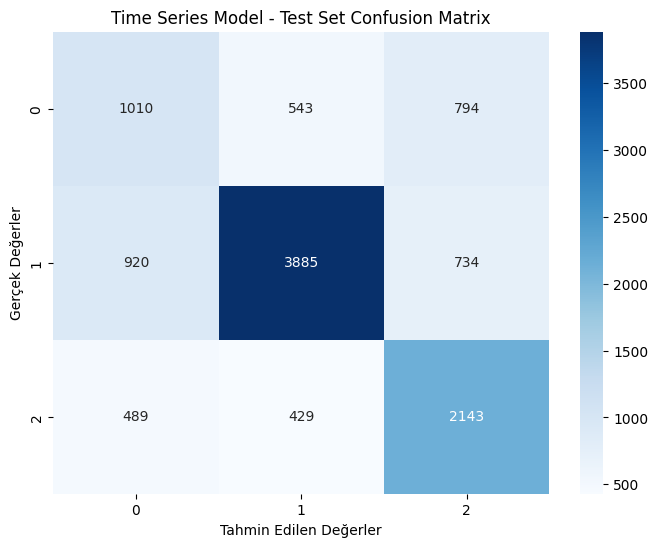


Validation Set Model Performance Metrics:
Sınıf  Precision   Recall  F1-score
    0   0.426326 0.417709  0.421974
    1   0.735064 0.684964  0.709130
    2   0.666570 0.731248  0.697412


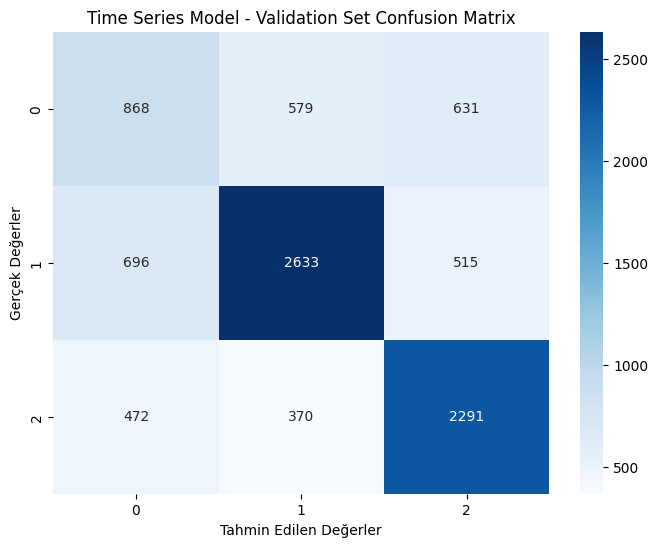

In [32]:

# Detaylı performans metrikleri
precision = precision_score(y_test, y_pred, labels=[0, 1, 2], average=None)
recall = recall_score(y_test, y_pred, labels=[0, 1, 2], average=None)
f1 = f1_score(y_test, y_pred, labels=[0, 1, 2], average=None)

metrics_df = pd.DataFrame({
    'Sınıf': ['0', '1', '2'],
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
})
print("\nTest Set Model Model Performance Metrics:")
print(metrics_df.to_string(index=False))

# Confusion Matrix görselleştirme
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Time Series Model - Test Set Confusion Matrix')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()


precision_val = precision_score(y_val, y_pred_val, labels=[0, 1, 2], average=None)
recall_val = recall_score(y_val, y_pred_val, labels=[0, 1, 2], average=None)
f1_val = f1_score(y_val, y_pred_val, labels=[0, 1, 2], average=None)

metrics_df_val = pd.DataFrame({
    'Sınıf': ['0', '1', '2'],
    'Precision': precision_val,
    'Recall': recall_val,
    'F1-score': f1_val
})
print("\nValidation Set Model Performance Metrics:")
print(metrics_df_val.to_string(index=False))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Time Series Model - Validation Set Confusion Matrix')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()



In [33]:

# Özellik önemliliklerini görüntüle
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nEn önemli 10 özellik:")
print(feature_importance.head(10))


En önemli 10 özellik:
              feature  importance
101       P_away_norm    0.045956
99        P_home_norm    0.042057
3                   1    0.039627
97             P_away    0.035815
4                   2    0.033244
95             P_home    0.031039
102  last_5_min_avg_1    0.030210
104  last_5_min_avg_2    0.029256
100       P_draw_norm    0.025206
96             P_draw    0.021635


/var/folders/ys/74vbprgx5wb7ggv44nbd6f240000gn/T/ipykernel_4648/2813062140.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combination_analysis = test_analysis.groupby(['minute', 'halftime']).apply(


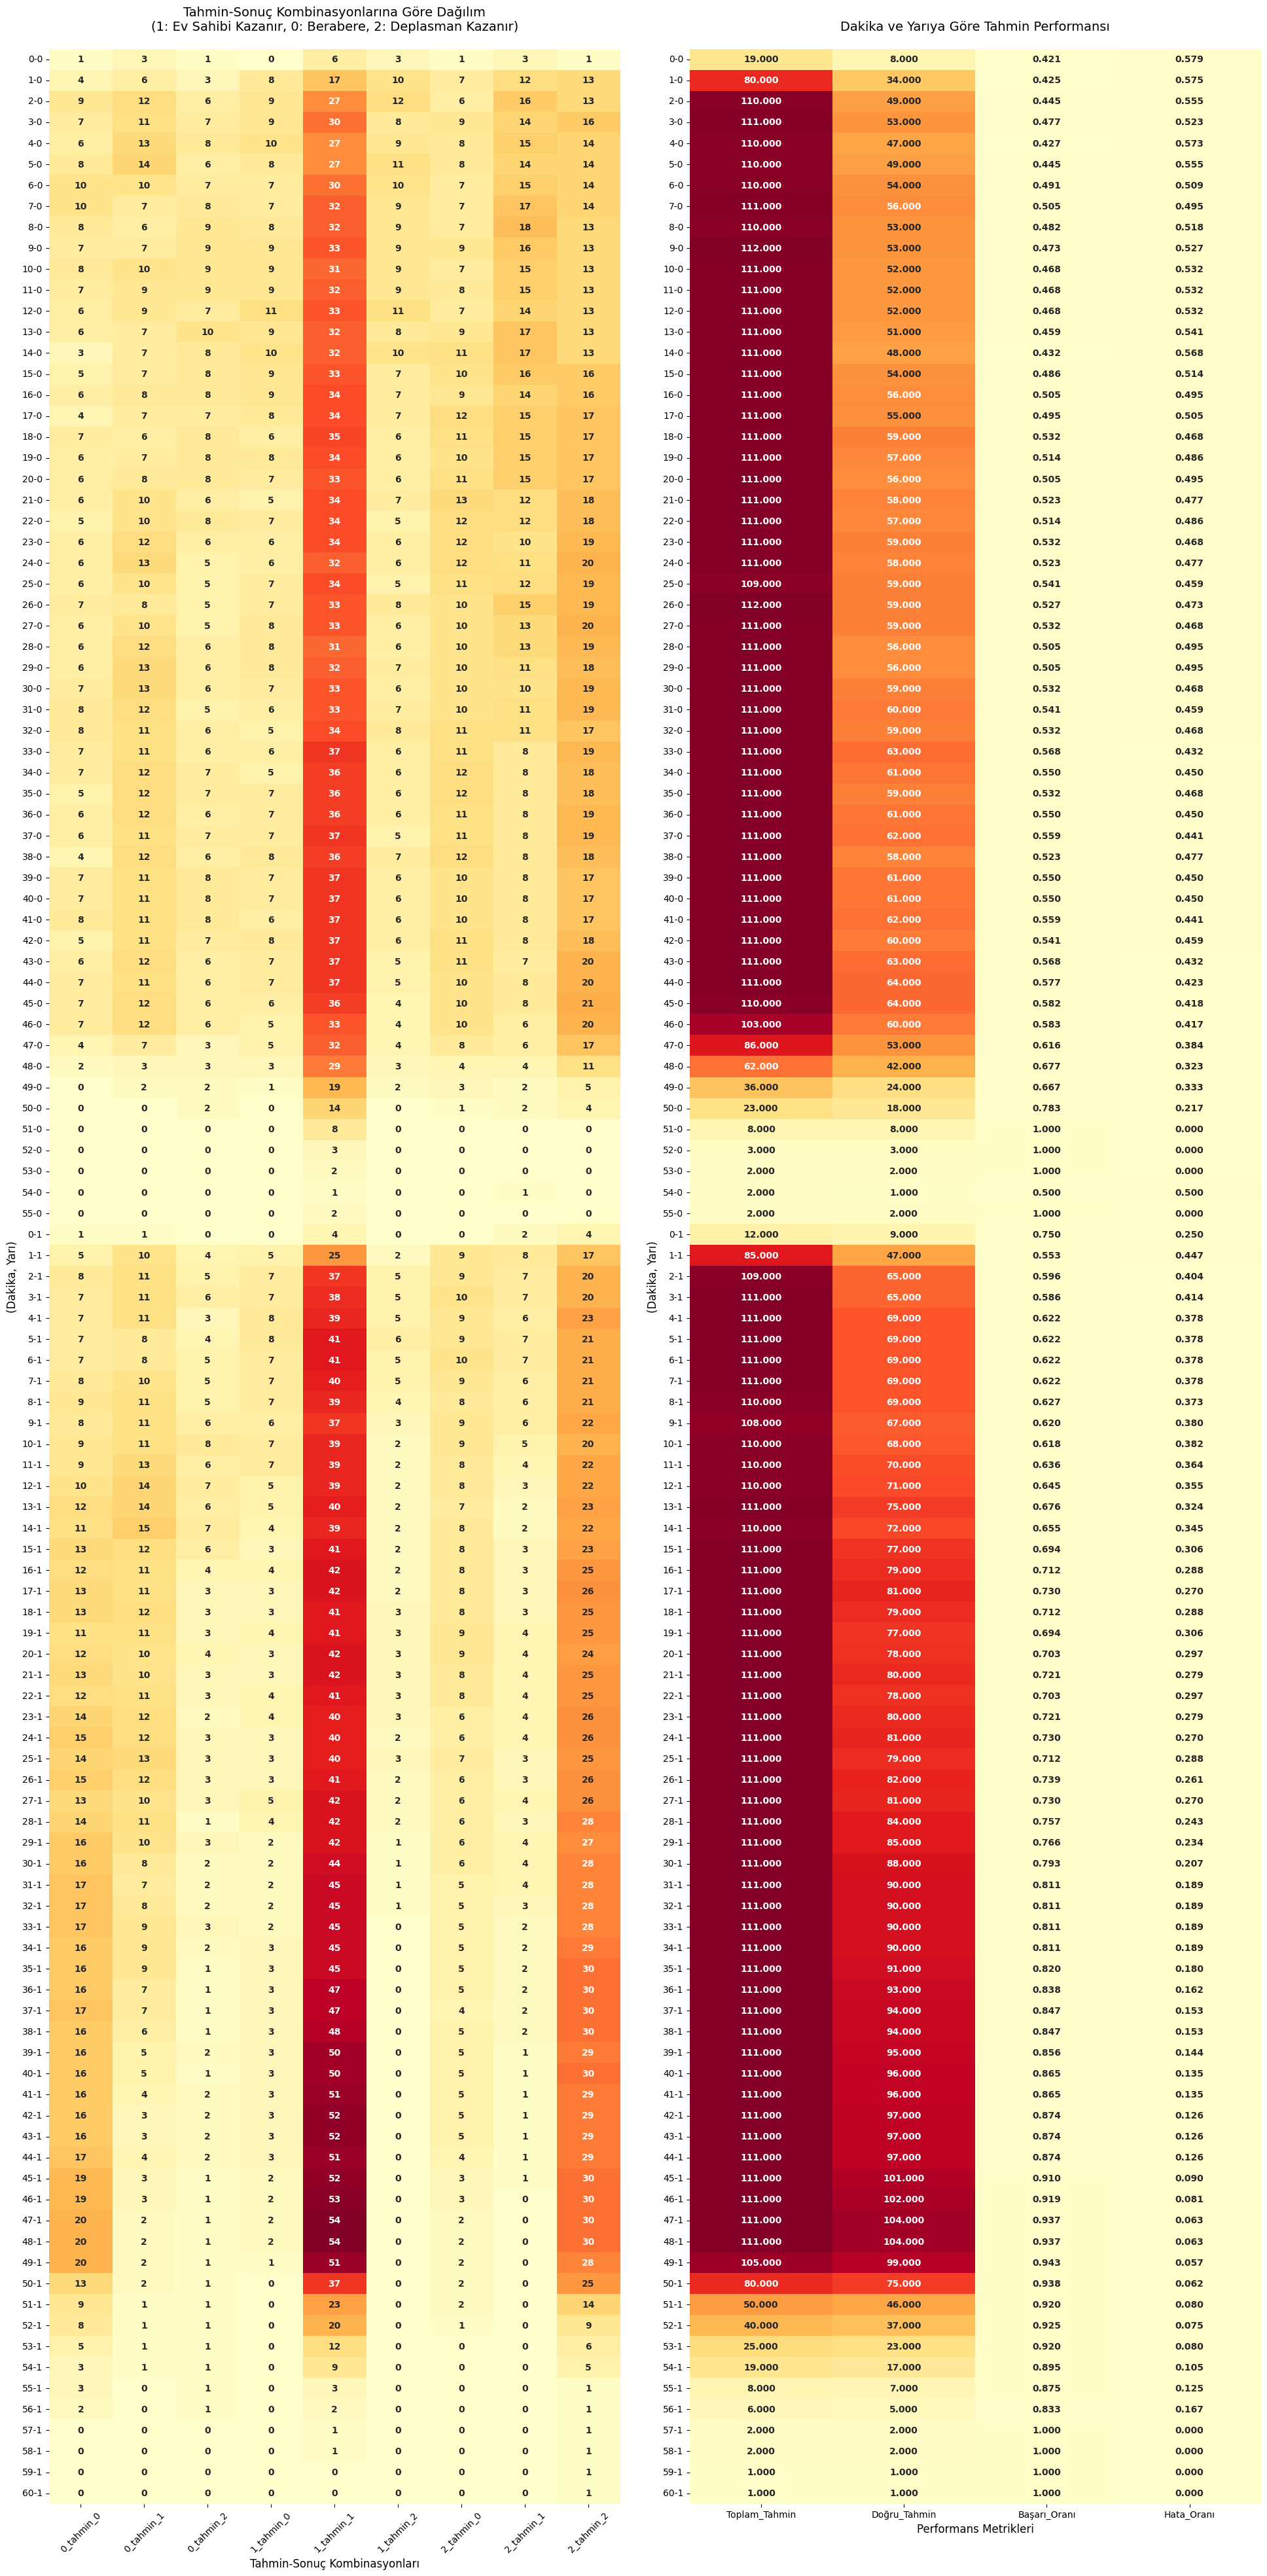

In [34]:
# Tahminleri ana veri setine ekleyelim
data.loc[test_data.index, 'predictions'] = y_pred
data.loc[validation_data.index, 'predictions'] = y_pred_val
# Test verisindeki tahminleri analiz edelim
test_analysis = test_data.copy()
test_analysis['predictions'] = y_pred

# Tahmin-sonuç kombinasyonlarını oluştur
test_analysis['prediction_result'] = test_analysis['predictions'].astype(str) + '_tahmin_' + test_analysis['result'].astype(str)

# Her kombinasyon için analiz
combination_analysis = test_analysis.groupby(['minute', 'halftime']).apply(
    lambda x: pd.Series({
        '0_tahmin_0': len(x[x['prediction_result'] == '0_tahmin_0']),
        '0_tahmin_1': len(x[x['prediction_result'] == '0_tahmin_1']),
        '0_tahmin_2': len(x[x['prediction_result'] == '0_tahmin_2']),
        '1_tahmin_0': len(x[x['prediction_result'] == '1_tahmin_0']),
        '1_tahmin_1': len(x[x['prediction_result'] == '1_tahmin_1']),
        '1_tahmin_2': len(x[x['prediction_result'] == '1_tahmin_2']),
        '2_tahmin_0': len(x[x['prediction_result'] == '2_tahmin_0']),
        '2_tahmin_1': len(x[x['prediction_result'] == '2_tahmin_1']),
        '2_tahmin_2': len(x[x['prediction_result'] == '2_tahmin_2'])
    })
).fillna(0)

# Toplam ve doğru tahminleri hesapla
test_analysis['correct'] = test_analysis['predictions'] == test_analysis['result']
summary_analysis = test_analysis.groupby(['minute', 'halftime']).agg({
    'fixture_id': 'count',  # toplam tahmin sayısı
    'correct': 'sum'  # doğru tahmin sayısı
}).sort_index(level=['halftime', 'minute'])

summary_analysis.columns = ['Toplam_Tahmin', 'Doğru_Tahmin']
summary_analysis['Başarı_Oranı'] = (summary_analysis['Doğru_Tahmin'] / summary_analysis['Toplam_Tahmin']).round(3)
summary_analysis['Hata_Oranı'] = (1 - summary_analysis['Başarı_Oranı']).round(3)

# Dakika bazında ortalama başarı oranları
minute_success = test_analysis.groupby('minute')['correct'].agg(['mean', 'count']).round(3)
minute_success.columns = ['Ortalama_Başarı', 'Toplam_Maç']

# Sonuçları görsel tablolar halinde göster
plt.figure(figsize=(20, 40))

# İlk tablo - Kombinasyon Analizi
plt.subplot(1, 2, 1)
combination_analysis = combination_analysis.sort_index(level=['halftime', 'minute'])  # Y eksenini halftime ve minute'a göre sırala
sns.heatmap(combination_analysis, annot=True, fmt='d', cmap='YlOrRd', 
            annot_kws={'size': 10, 'weight': 'bold'}, cbar=False)  # Renk barını kaldırdık
plt.title('Tahmin-Sonuç Kombinasyonlarına Göre Dağılım\n(1: Ev Sahibi Kazanır, 0: Berabere, 2: Deplasman Kazanır)', 
          fontsize=14, pad=20)
plt.xlabel('Tahmin-Sonuç Kombinasyonları', fontsize=12)
plt.ylabel('(Dakika, Yarı)', fontsize=12)
plt.xticks(rotation=45)

# İkinci tablo - Özet Analiz
plt.subplot(1, 2, 2)
sns.heatmap(summary_analysis, annot=True, fmt='.3f', cmap='YlOrRd',
            annot_kws={'size': 10, 'weight': 'bold'}, cbar=False)  # Renk barını kaldırdık
plt.title('Dakika ve Yarıya Göre Tahmin Performansı', fontsize=14, pad=20)
plt.xlabel('Performans Metrikleri', fontsize=12)
plt.ylabel('(Dakika, Yarı)', fontsize=12)

plt.tight_layout(pad=3.0)
plt.show()


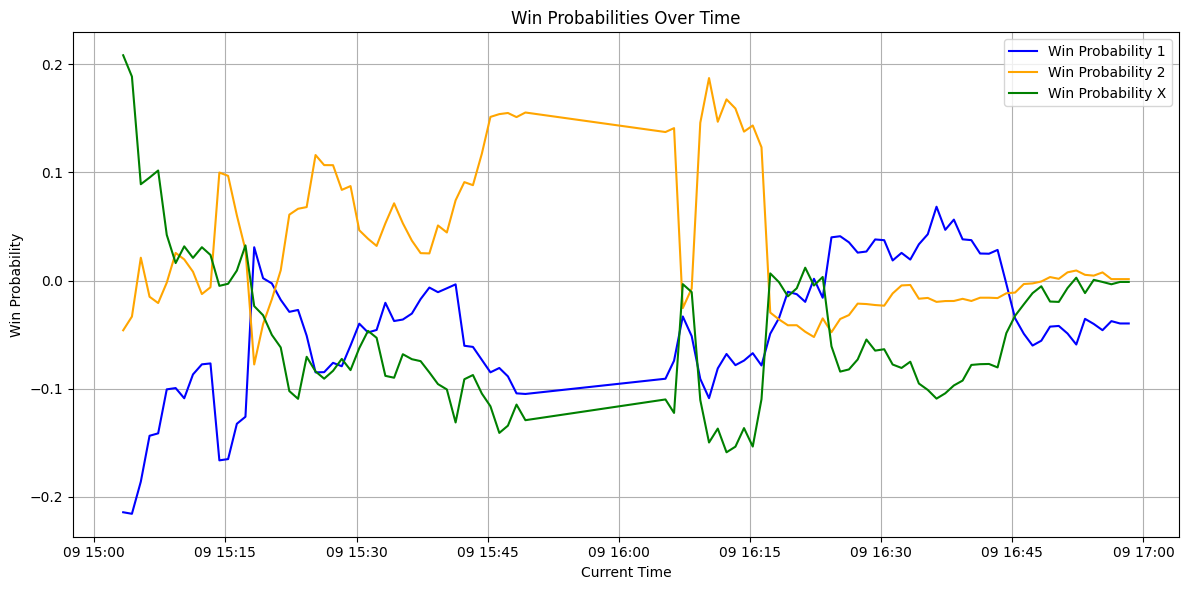

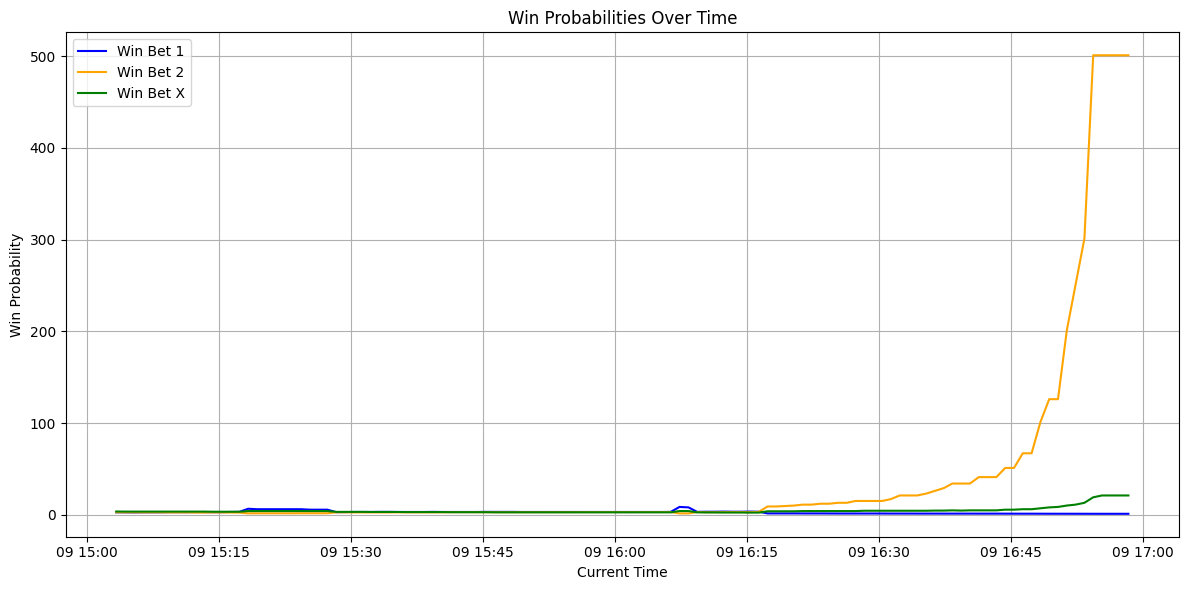

In [35]:
plt.figure(figsize=(12, 6))
filtered_data = data[data['fixture_id'] == 19134533.0]
plt.plot(filtered_data['current_time'], (filtered_data['win_probability_1'] - (1/filtered_data['1'])), label='Win Probability 1', color='blue')
plt.plot(filtered_data['current_time'], (filtered_data['win_probability_2'] - (1/filtered_data['2'])), label='Win Probability 2', color='orange')
plt.plot(filtered_data['current_time'], (filtered_data['win_probability_X'] - (1/filtered_data['X'])), label='Win Probability X', color='green')
plt.title('Win Probabilities Over Time')
plt.xlabel('Current Time')
plt.ylabel('Win Probability')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
filtered_data = data[data['fixture_id'] == 19134533.0]
plt.plot(filtered_data['current_time'], filtered_data['1'], label='Win Bet 1', color='blue')
plt.plot(filtered_data['current_time'], filtered_data['2'], label='Win Bet 2', color='orange')
plt.plot(filtered_data['current_time'], filtered_data['X'], label='Win Bet X', color='green')
plt.title('Win Probabilities Over Time')
plt.xlabel('Current Time')
plt.ylabel('Win Probability')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [36]:
# İddia oynama ve puan hesaplama
data['points'] = 0.0  # Puanları tutmak için yeni bir sütun ekleyelim, float olarak başlatıyoruz
data['bet_made'] = False  # İddia yapılıp yapılmadığını kontrol etmek için

# Kazanma olasılığı için eşik değerleri ve row'lar için olasılık aralıkları
thresholds = [round(0.33 + i * 0.01, 2) for i in range(13)]  
row_probabilities = [round(1.8 + i * 0.1, 1) for i in range(8)]

#thresholds = [0.7]
#row_probabilities = [1.9]

# Fixture ID'leri için bir set oluştur
played_fixtures = set()

# İddia oynama ve puan hesaplama
total_bets = 0  # İddia oynanan maç sayısı
total_points = 0.0  # Toplam puan, float olarak başlatıyoruz
correct_predictions = 0  # Doğru tahmin sayısı

# Fixture ID'lerine göre toplam maç sayısını belirle
total_matches = data['fixture_id'].nunique()  # Toplam fixture_id sayısını al

# DataFrame'i current_time'a göre sıralama
data = data.sort_values(by='current_time')

# Sonuçları saklamak için bir liste
results = []
bet_made_true_rows = []  # Bet yapılmış satırları saklamak için yeni bir liste

for threshold in thresholds:
    for row_prob in row_probabilities:
        # Her kombinasyon için toplam puanları sıfırla
        total_points_combination = 0.0
        total_bets_combination = 0  # İddia oynanan maç sayısını sıfırla
        correct_predictions_combination = 0  # Doğru tahmin sayısını sıfırla
        
        # Fixture ID'lerine göre gruplama ve sıralama
        for fixture_id, fixture_data in data.groupby('fixture_id'):
            fixture_data = fixture_data.sort_values(by='current_time')  # Her fixture_id için current_time'a göre sıralama
            
            # İddia oynama kararı için bir bayrak
            bet_made_for_fixture = False
            
            for index, row in fixture_data.iterrows():
                if (not row['bet_made'] and 
                    row['current_time'] >=  pd.Timestamp(validation_start_date) and row['current_time'] < pd.Timestamp(test_start_date) and
                    #row['current_time'] <= pd.Timestamp.now() and 
                    not bet_made_for_fixture):  # İddia yapılmamış ve geçerli zaman, sadece bir iddia oynanacak
                
                    # Kazanma olasılıklarını kontrol et
                    win_prob_1 = row['win_probability_1']
                    win_prob_2 = row['win_probability_2']
                    win_prob_X = row['win_probability_X']
                    
                    # İddia oynama kararı
                    prediction = None
                    max_prob = max(win_prob_1, win_prob_2, win_prob_X)  # En yüksek olasılığı bul
                    if win_prob_1 == max_prob and win_prob_1 > threshold and row['1'] > row_prob and win_prob_1 <= (1 / row['1']):
                        prediction = 1  # Ev sahibi kazanır
                    elif win_prob_2 == max_prob and win_prob_2 > threshold and row['2'] > row_prob and win_prob_2 <= (1 / row['2']):
                        prediction = 2  # Deplasman
                    elif win_prob_X == max_prob and win_prob_X > threshold and row['X'] > row_prob and win_prob_X <= (1 / row['X']):
                        prediction = 0  # Beraberlik
                    
                    if prediction is not None:
                        # Bet yapılacak satırı kaydet
                        bet_made_true_rows.append(row)  # Bet yapılacak satırı ekle
                        # İddia yapıldı
                        data.at[index, 'bet_made'] = True  # Değişiklik burada yapılıyor
                        played_fixtures.add(row['fixture_id'])  # Fixture ID'yi ekle
                        total_bets_combination += 1  # İddia oynanan maç sayısını artır
                        bet_made_for_fixture = True  # Bu fixture için iddia yapıldı
                        
                        # Gerçek sonuç ile tahmini karşılaştır
                        if row['result'] == prediction:
                            # Kazanma durumu, puanı doğrudan ilgili kolondan al
                            if prediction == 0:
                                data.at[index, 'points'] += row['X'] - 1  # Beraberlik
                            elif prediction == 1:
                                data.at[index, 'points'] += row['1'] - 1  # Ev
                            elif prediction == 2:
                                data.at[index, 'points'] += row['2'] - 1  # Deplasman kazanır
                            total_points_combination += data.at[index, 'points']  # Toplam puanı güncelle
                            correct_predictions_combination += 1  # Doğru tahmin sayısını artır
                        else:
                            # Kaybetme durumu
                            data.at[index, 'points'] -= 1
                            total_points_combination += data.at[index, 'points']  # Toplam puanı güncelle

        # Her kombinasyon için sonuçları sakla
        results.append({
            'Threshold': threshold,
            'Row Probability': row_prob,
            'Total Bets': total_bets_combination,
            'Total Points': total_points_combination,
            'Correct Prediction Rate': correct_predictions_combination / total_bets_combination if total_bets_combination > 0 else 0
        })

        # Her kombinasyon için bet_made'leri false'a çek ve points'i sıfırla
        data['bet_made'] = False
        data['points'] = 0.0  # points'i sıfırla, float olarak

        # Her kombinasyon için sonuçları print et
        print(f"Threshold: {threshold}, Row Probability: {row_prob}, Total Bets: {total_bets_combination}, Total Points: {total_points_combination}, Correct Prediction Rate: {correct_predictions_combination / total_bets_combination if total_bets_combination > 0 else 0}")

# DataFrame olarak sonuçları çıkar ve toplam puana göre sırala
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Total Points', ascending=False)  # Total Points'e göre büyükten küçüğe sırala
results_df


Threshold: 0.33, Row Probability: 1.8, Total Bets: 67, Total Points: -6.550000000000001, Correct Prediction Rate: 0.417910447761194
Threshold: 0.33, Row Probability: 1.9, Total Bets: 59, Total Points: -3.290000000000001, Correct Prediction Rate: 0.423728813559322
Threshold: 0.33, Row Probability: 2.0, Total Bets: 55, Total Points: -3.090000000000001, Correct Prediction Rate: 0.41818181818181815
Threshold: 0.33, Row Probability: 2.1, Total Bets: 43, Total Points: -2.9899999999999998, Correct Prediction Rate: 0.3953488372093023
Threshold: 0.33, Row Probability: 2.2, Total Bets: 38, Total Points: 2.3599999999999994, Correct Prediction Rate: 0.4473684210526316
Threshold: 0.33, Row Probability: 2.3, Total Bets: 32, Total Points: 4.410000000000004, Correct Prediction Rate: 0.46875
Threshold: 0.33, Row Probability: 2.4, Total Bets: 21, Total Points: 1.9900000000000002, Correct Prediction Rate: 0.42857142857142855
Threshold: 0.33, Row Probability: 2.5, Total Bets: 12, Total Points: -3.88999999

,Threshold,Row Probability,Total Bets,Total Points,Correct Prediction Rate
21,0.35,2.3,31,5.41,0.483871
37,0.37,2.3,27,4.67,0.481481
20,0.35,2.2,38,4.61,0.473684
44,0.38,2.2,31,4.42,0.483871
13,0.34,2.3,32,4.41,0.468750
...,...,...,...,...,...
64,0.41,1.8,51,-10.56,0.392157
72,0.42,1.8,49,-11.06,0.387755
96,0.45,1.8,35,-11.63,0.342857
88,0.44,1.8,41,-11.73,0.365854


In [37]:
results_df['Profit Margin'] = ((results_df['Total Bets'] + results_df['Total Points']) / results_df['Total Bets']) - 1
results_df = results_df.sort_values(by='Profit Margin', ascending=False)  # Yeni kolona göre büyükten küçüğe sırala

results_df[results_df['Total Bets'] >= 10].head(20)

results_df.head(20)

,Threshold,Row Probability,Total Bets,Total Points,Correct Prediction Rate,Profit Margin
54,0.39,2.4,7,3.00,0.571429,0.428571
53,0.39,2.3,18,3.75,0.500000,0.208333
38,0.37,2.4,15,2.62,0.466667,0.174667
21,0.35,2.3,31,5.41,0.483871,0.174516
37,0.37,2.3,27,4.67,0.481481,0.172963
45,0.38,2.3,23,3.65,0.478261,0.158696
46,0.38,2.4,13,2.00,0.461538,0.153846
44,0.38,2.2,31,4.42,0.483871,0.142581
13,0.34,2.3,32,4.41,0.468750,0.137813
5,0.33,2.3,32,4.41,0.468750,0.137813


In [38]:
# Total Bets'i 0 olmayanları filtrele
filtered_results_df = results_df[results_df['Total Bets'] > 5]

# Row Probability'ye göre gruplama ve ortalamaları ile standart sapmaları hesaplama
grouped_results = filtered_results_df.groupby('Row Probability').agg({
    'Profit Margin': ['mean', 'std'],
    'Correct Prediction Rate': ['mean', 'std']
}).reset_index()

# Kolon adlarını düzelterek daha okunabilir hale getirme
grouped_results.columns = ['Row Probability', 'Profit Margin Mean', 'Profit Margin Std', 
                           'Correct Prediction Rate Mean', 'Correct Prediction Rate Std']

# Sonuçları bir tablo olarak gösterme
grouped_results

,Row Probability,Profit Margin Mean,Profit Margin Std,Correct Prediction Rate Mean,Correct Prediction Rate Std
0,1.8,-0.172959,0.089427,0.399342,0.027794
1,1.9,-0.104736,0.110934,0.415815,0.042188
2,2.0,-0.092281,0.106303,0.413578,0.041957
3,2.1,-0.118937,0.090913,0.382241,0.032721
4,2.2,0.054451,0.090912,0.450126,0.034493
5,2.3,0.064151,0.202254,0.439893,0.081305
6,2.4,0.148861,0.132601,0.455656,0.055000
7,2.5,-0.389067,0.079813,0.230000,0.027386


İlk bakışta 2.4 doğru tahmin oranı ve profit margin'ine göre seçilebilecek en iyi değer olsa bile standart sapması çok yüksek değere sahiptir ve bu riskli bir seçim doğurabilir. Doğru tahmin oranı ve kar marjını dengeleyebilmek için 2.2 aralarındaki en iyi seçimdir. 

In [39]:
# Total Bets'i 0 olmayanları filtrele
filtered_results_df = results_df[results_df['Total Bets'] > 5]

# Threshold'a göre gruplama ve ortalamaları ile standart sapmaları hesaplama
grouped_results = filtered_results_df.groupby('Threshold').agg({
    'Profit Margin': ['mean', 'std'],
    'Correct Prediction Rate': ['mean', 'std']
}).reset_index()

# Kolon adlarını düzelterek daha okunabilir hale getirme
grouped_results.columns = ['Threshold', 'Profit Margin Mean', 'Profit Margin Std', 
                           'Correct Prediction Rate Mean', 'Correct Prediction Rate Std']

# Sonuçları bir tablo olarak gösterme
grouped_results

,Threshold,Profit Margin Mean,Profit Margin Std,Correct Prediction Rate Mean,Correct Prediction Rate Std
0,0.33,-0.038591,0.144250,0.406232,0.066775
1,0.34,-0.038591,0.144250,0.406232,0.066775
2,0.35,-0.020345,0.198012,0.417412,0.090361
3,0.36,-0.070554,0.184837,0.396871,0.083205
4,0.37,-0.016669,0.172334,0.417782,0.073547
5,0.38,0.042769,0.109797,0.451482,0.029327
6,0.39,0.076304,0.197814,0.468341,0.058807
7,0.40,-0.072457,0.101409,0.420439,0.046160
8,0.41,-0.162297,0.134039,0.381408,0.066978
9,0.42,-0.188382,0.048764,0.376945,0.028544


Bu tabloya baktığımızda da 0.39 ve 0.38'in pozitif kar marjı ve çok daha yüksek doğruluk oranları nedeniyle seçilmesi doğru olacaktır. Ancak bu değerler 2.4'ün en iyi olduğu durum için geçerlidir. Row probability ve threshold arasında hesaplama nedeniyle ters bir orantı mevcuttur. Bu yüzden biz 2.2 row probability seçeceğimiz için 0.39'dan daha büyük bir değer seçmek daha doğru olacaktır:

2.4 --- 0.39

2.2 --- ≈0.42

In [40]:
# İddia oynama ve puan hesaplama
data['points'] = 0.0  # Puanları tutmak için yeni bir sütun ekleyelim, float olarak başlatıyoruz
data['bet_made'] = False  # İddia yapılıp yapılmadığını kontrol etmek için

# Kazanma olasılığı için eşik değerleri ve row'lar için olasılık aralıkları
#thresholds_test = [round(0.35+ i * 0.01, 2) for i in range(11)]  
#row_probabilities_test = [round(2 + i * 0.1, 1) for i in range(6)]
### train setine göre en iyi threshold ve row probability 0.40 ve 2.0
thresholds_test = [0.39,0.42]
row_probabilities_test = [2.2]

# Fixture ID'leri için bir set oluştur
played_fixtures_test = set()

# İddia oynama ve puan hesaplamalar
total_bets_test = 0  # İddia oynanan maç sayısı
total_points_test = 0.0  # Toplam puan, float olarak başlatıyoruz
correct_predictions_test = 0  # Doğru tahmin sayısı

# Fixture ID'lerine göre toplam maç sayısını belirle
total_matches_test = data['fixture_id'].nunique()  # Toplam fixture_id sayısını al

# DataFrame'i current_time'a göre sıralama
data = data.sort_values(by='current_time')

# Sonuçları saklamak için bir liste
results_test = []
bet_made_true_rows_test = []  # Bet yapılmış satırları saklamak için yeni bir liste

for threshold in thresholds_test:
    for row_prob in row_probabilities_test:
        # Her kombinasyon için toplam puanları sıfırla
        total_points_combination_test = 0.0
        total_bets_combination_test = 0  # İddia oynanan maç sayısını sıfırla
        correct_predictions_combination_test = 0  # Doğru tahmin sayısını sıfırla
        
        # Fixture ID'lerine göre gruplama ve sıralama
        for fixture_id, fixture_data in data.groupby('fixture_id'):
            fixture_data = fixture_data.sort_values(by='current_time')  # Her fixture_id için current_time'a göre sıralama
            
            # İddia oynama kararı için bir bayrak
            bet_made_for_fixture_test = False
            
            for index, row in fixture_data.iterrows():
                if (not row['bet_made'] and 
                    row['current_time'] >= pd.Timestamp(test_start_date) and 
                    row['current_time'] <= pd.Timestamp.now() and 
                    not bet_made_for_fixture_test):  # İddia yapılmamış ve geçerli zaman, sadece bir iddia oynanacak
                
                    # Kazanma olasılıklarını kontrol et
                    win_prob_1 = row['win_probability_1']
                    win_prob_2 = row['win_probability_2']
                    win_prob_X = row['win_probability_X']
                    
                    # İddia oynama kararı
                    prediction = None
                    max_prob = max(win_prob_1, win_prob_2, win_prob_X)  # En yüksek olasılığı bul
                    if win_prob_1 == max_prob and win_prob_1 > threshold and row['1'] > row_prob and win_prob_1 <= (1 / row['1']):
                        prediction = 1  # Ev sahibi kazanır
                    elif win_prob_2 == max_prob and win_prob_2 > threshold and row['2'] > row_prob and win_prob_2 <= (1 / row['2']):
                        prediction = 2  # Deplasman
                    elif win_prob_X == max_prob and win_prob_X > threshold and row['X'] > row_prob and win_prob_X <= (1 / row['X']):
                        prediction = 0  # Beraberlik
                    
                    if prediction is not None:
                        # Bet yapılacak satırı kaydet
                        bet_made_true_rows_test.append(row)  # Bet yapılacak satırı ekle
                        # İddia yapıldı
                        data.at[index, 'bet_made'] = True  # Değişiklik burada yapılıyor
                        played_fixtures_test.add(row['fixture_id'])  # Fixture ID'yi ekle
                        total_bets_combination_test += 1  # İddia oynanan maç sayısını artır
                        bet_made_for_fixture_test = True  # Bu fixture için iddia yapıldı
                        
                        # Gerçek sonuç ile tahmini karşılaştır
                        if row['result'] == prediction:
                            # Kazanma durumu, puanı doğrudan ilgili kolondan al
                            if prediction == 0:
                                data.at[index, 'points'] += row['X'] - 1  # Beraberlik
                            elif prediction == 1:
                                data.at[index, 'points'] += row['1'] - 1  # Ev
                            elif prediction == 2:
                                data.at[index, 'points'] += row['2'] - 1  # Deplasman kazanır
                            total_points_combination_test += data.at[index, 'points']  # Toplam puanı güncelle
                            correct_predictions_combination_test += 1  # Doğru tahmin sayısını artır
                        else:
                            # Kaybetme durumu
                            data.at[index, 'points'] -= 1
                            total_points_combination_test += data.at[index, 'points']  # Toplam puanı güncelle

        # Her kombinasyon için sonuçları sakla
        results_test.append({
            'Threshold': threshold,
            'Row Probability': row_prob,
            'Total Bets': total_bets_combination_test,
            'Total Points': total_points_combination_test,
            'Correct Prediction Rate': correct_predictions_combination_test / total_bets_combination_test if total_bets_combination_test > 0 else 0
        })

        # Her kombinasyon için bet_made'leri false'a çek ve points'i sıfırla
        data['bet_made'] = False
        data['points'] = 0.0  # points'i sıfırla, float olarak

        # Her kombinasyon için sonuçları print et
        print(f"Threshold: {threshold}, Row Probability: {row_prob}, Total Bets: {total_bets_combination_test}, Total Points: {total_points_combination_test}, Correct Prediction Rate: {correct_predictions_combination_test / total_bets_combination_test if total_bets_combination_test > 0 else 0}")

# DataFrame olarak sonuçları çıkar ve toplam puana göre sırala
results_df_test = pd.DataFrame(results_test)
results_df_test = results_df_test.sort_values(by='Total Points', ascending=False)  # Total Points'e göre büyükten küçüğe sırala
results_df_test


Threshold: 0.39, Row Probability: 2.2, Total Bets: 42, Total Points: 2.149999999999999, Correct Prediction Rate: 0.4523809523809524
Threshold: 0.42, Row Probability: 2.2, Total Bets: 20, Total Points: 2.7699999999999996, Correct Prediction Rate: 0.5


,Threshold,Row Probability,Total Bets,Total Points,Correct Prediction Rate
1,0.42,2.2,20,2.77,0.500000
0,0.39,2.2,42,2.15,0.452381


In [41]:
results_df_test['Profit Margin'] = ((results_df_test['Total Bets'] + results_df_test['Total Points']) / results_df_test['Total Bets']) - 1
results_df_test = results_df_test.sort_values(by='Profit Margin', ascending=False)  # Yeni kolona göre büyükten küçüğe sırala

results_df_test.head(20)


,Threshold,Row Probability,Total Bets,Total Points,Correct Prediction Rate,Profit Margin
1,0.42,2.2,20,2.77,0.500000,0.13850
0,0.39,2.2,42,2.15,0.452381,0.05119
